# Calculate dynamic height from CTD profiles

In [165]:
import numpy as np
import xarray as xr
import pandas as pd
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
from pyresample import geometry, kd_tree
import os

Open satellite data

In [4]:
ssh_1993 = xr.open_dataset('/Users/mzahn/data/SSH/cmems_ssh_yearly/ssh_cmems_l4_0pt125deg_50N_65N_60W_40W_1993.nc')
ssh_2024 = xr.open_dataset('/Users/mzahn/data/SSH/cmems_ssh_yearly/ssh_cmems_l4_0pt125deg_50N_65N_60W_40W_2024.nc')

In [5]:
ssh_1993_day = ssh_1993.sla.sel(time='1993-06-21') # midpoint in CTD profile sampling period

In [8]:
ssh_2024_day = ssh_2024.sla.sel(time='2024-06-12') # midpoint in CTD profile sampling period

Open CTD data

In [10]:
# open ctd data from WOCE line AR7W from 1993
ar7w_1993_ds = xr.open_dataset('/Users/mzahn/data/Labrador_AR7W/cchdo_AR07W/3_18HU93019_1_ctd.nc')

In [20]:
wod_ctd_ds = xr.open_mfdataset('/Users/mzahn/data/Labrador_AR7W/ocldb1769457252.646961.CTD/ocldb1769457252.646961.CTD.nc')

### Find location of 2024 profiles that match 1993 profile locations

In [ ]:
lats = ar7w_1993_ds.latitude
lons = ar7w_1993_ds.longitude

In [52]:
len(valid_target_idx)

27

In [56]:
valid_target_idx

array([       inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf,        inf,        inf,        inf,        inf,
              inf, 0.35355338, 0.5       , 0.        , 0.9013878 ,
       0.25      , 0.61237246, 0.        , 0.35355338, 0.6731456 ,
       0.125     , 0.2795085 ], dtype=float32)

In [61]:
idx_valid

array([1789, 1789, 1789, 1789, 1789, 1789, 1789, 1789, 1789, 1789, 1789,
       1789, 1789, 1789, 1789,  935,  109,  110,  111,  112,  113,  114,
        115,  116,  117,  118,  119], dtype=uint32)

In [65]:
len(wod_ctd_ds.casts.values)

1789

In [71]:
wod_ctd_ds.isel(casts=1789-1)

<xarray.Dataset> Size: 20B
Dimensions:  ()
Data variables:
    lat      float32 4B dask.array<chunksize=(), meta=np.ndarray>
    lon      float32 4B dask.array<chunksize=(), meta=np.ndarray>
    time     datetime64[ns] 8B dask.array<chunksize=(), meta=np.ndarray>
    cast     int32 4B dask.array<chunksize=(), meta=np.ndarray>

In [128]:
# Match WOD CTD profiles to AR7W stations using pyresample (nearest neighbor)

# --- extract coordinates ---
ar_lats, ar_lons = ar7w_1993_ds.latitude.values, ar7w_1993_ds.longitude.values
wod_lats, wod_lons = wod_ctd_ds.lat.values, wod_ctd_ds.lon.values

# --- define swaths (scattered point geometry) ---
ar_swath  = geometry.SwathDefinition(lons=ar_lons,  lats=ar_lats)
wod_swath = geometry.SwathDefinition(lons=wod_lons, lats=wod_lats)

# --- nearest neighbor search ---
idx, dist, idx_valid, dist_valid = kd_tree.get_neighbour_info(
    source_geo_def=wod_swath,
    target_geo_def=ar_swath,
    radius_of_influence=5e4,
    neighbours=1)

# a bunch of ctds are out of range, so drop those ones (=last index of wod_ctd_ds array)
idx_valid = idx_valid[np.where(idx_valid!=len(wod_ctd_ds.casts))]

wod_ar7w_2024 = wod_ctd_ds.isel(casts=idx_valid[1:])

### Open WOD profiles

In [22]:
osd_ds = xr.open_mfdataset('/Users/mzahn/data/Labrador_AR7W/ocldb1769457252.646961.OSD/ocldb1769457252.646961.OSD.nc')
ctd_ds = xr.open_mfdataset('/Users/mzahn/data/Labrador_AR7W/ocldb1769457252.646961.CTD/ocldb1769457252.646961.CTD.nc')

In [24]:
osd_ds = osd_ds.swap_dims({'casts':'time'})
ctd_ds = ctd_ds.swap_dims({'casts':'time'})

In [26]:
# select 2024
osd_2024 = osd_ds.sel(time='2024') # none from 2024
ctd_2024 = ctd_ds.sel(time='2024')

In [57]:
ctd_2024.time.values

array(['2024-05-31T00:56:15.000000512', '2024-05-31T06:56:15.000000512',
       '2024-05-31T13:18:44.999999488', '2024-05-31T19:18:44.999999488',
       '2024-05-31T23:48:44.999999488', '2024-06-01T05:37:30.000000000',
       '2024-06-01T09:22:30.000000000', '2024-06-01T15:33:44.999999488',
       '2024-06-01T19:41:15.000000512', '2024-06-02T00:56:15.000000512',
       '2024-06-02T04:41:15.000000512', '2024-06-02T09:56:15.000000512',
       '2024-06-02T14:03:44.999999488', '2024-06-02T18:45:00.000000000',
       '2024-06-02T22:07:30.000000000', '2024-06-03T02:26:15.000000512',
       '2024-06-03T06:56:15.000000512', '2024-06-03T09:33:44.999999488',
       '2024-06-03T14:37:30.000000000', '2024-06-03T15:45:00.000000000',
       '2024-06-03T18:33:44.999999488', '2024-06-03T21:22:30.000000000',
       '2024-06-04T00:45:00.000000000', '2024-06-04T04:52:30.000000000',
       '2024-06-04T07:52:30.000000000', '2024-06-04T15:33:44.999999488',
       '2024-06-04T21:45:00.000000000', '2024-06-05

### Plot

/Users/mzahn/miniforge3/envs/sassie/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)


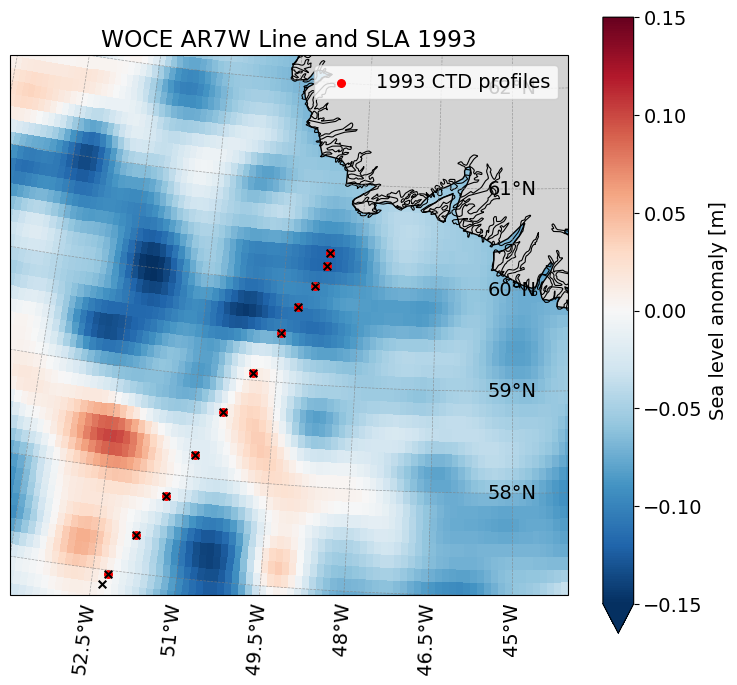

In [119]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))

# Add map features
# ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='lightgray'))
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.8)

# Optional: gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True

# Set extent: focus on high northern latitudes (e.g., above 50N)
ax.set_extent([-54, -44, 57, 62], crs=ccrs.PlateCarree())

# plot ssh
ssh_1993_day.plot(vmin=-0.15,vmax=0.15,cmap='RdBu_r',transform=ccrs.PlateCarree())

# Plot points for 1993
ar7w_1993_ds.plot.scatter(
    x='longitude',
    y='latitude',
    ax=ax,
    color='red',
    s=30,
    transform=ccrs.PlateCarree(),
    label='1993 CTD profiles'
)

# Plot points for 2024
ax.scatter(
    wod_ar7w_2024.lon.values,
    wod_ar7w_2024.lat.values,
    s=30,
    color="k", marker='x',
    transform=ccrs.PlateCarree())

# Title and legend
plt.title("WOCE AR7W Line and SLA 1993")
plt.legend()
plt.show()

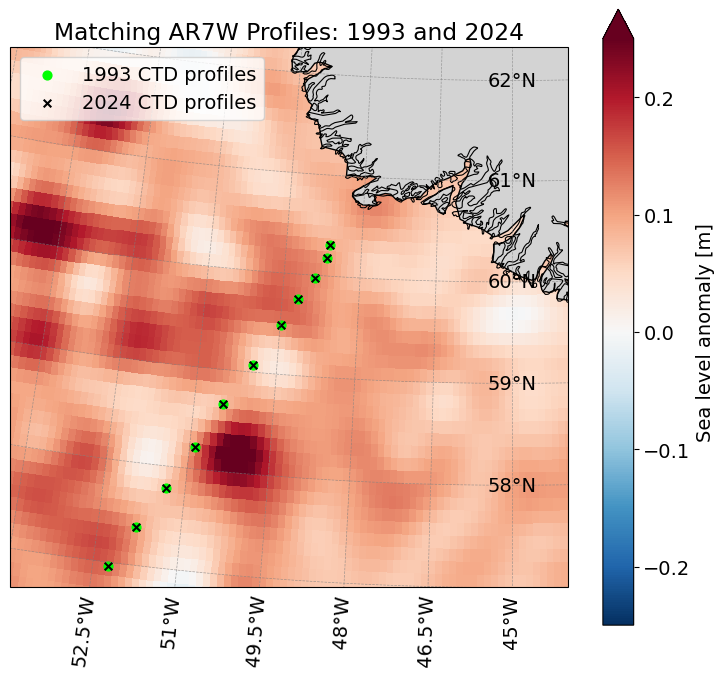

In [138]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize=(9, 8))
ax = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-45))

# Add map features
# ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='lightgray'))
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
ax.add_feature(cfeature.BORDERS, linewidth=0.8)

# Optional: gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.left_labels = True
gl.bottom_labels = True

# Set extent: focus on high northern latitudes (e.g., above 50N)
ax.set_extent([-54, -44, 57, 62], crs=ccrs.PlateCarree())

# plot ssh
ssh_2024_day.plot(vmin=-0.25,vmax=0.25,cmap='RdBu_r',transform=ccrs.PlateCarree())

# Plot points for 1993
ar7w_1993_ds.plot.scatter(
    x='longitude',
    y='latitude',
    ax=ax,
    color='lime',
    s=40,
    transform=ccrs.PlateCarree(),
    label='1993 CTD profiles'
)

# Plot points for 2024
ax.scatter(
    wod_ar7w_2024.lon.values,
    wod_ar7w_2024.lat.values,
    s=30,
    color="k", marker='x',
    transform=ccrs.PlateCarree(),
    label='2024 CTD profiles')

# Title and legend
plt.title("Matching AR7W Profiles: 1993 and 2024")
plt.legend(loc='upper left')
plt.show()

## Calculate dynamic height

https://www.teos-10.org/pubs/gsw/html/gsw_geo_strf_dyn_height.html

In [213]:
wod_ctd_dir = '/Users/mzahn/data/Labrador_AR7W/ocldb1769457252.646961.CTD'
file_list = glob.glob(f'{wod_ctd_dir}/*.nc')

# Initialize lists to store results
dynamic_height_list = []
lat_list = []
lon_list = []

# Loop over casts in dataset
for i in range(len(wod_ar7w_2024.casts)):
    wod_id = wod_ar7w_2024.isel(casts=i).cast.values
    # print(f"Processing cast: {wod_id}")

    # find the corresponding file
    matched_files = [f for f in file_list if str(wod_id) in os.path.basename(f)]
    if not matched_files:
        print(f"No file found for cast {wod_id}")
        continue

    ctd_file = matched_files[0]
    ds = xr.open_dataset(ctd_file)

    # Extract vars
    P = ds['Pressure'].values
    T = ds['Temperature'].values
    S = ds['Salinity'].values 
    lat = ds['lat'].values
    lon = ds['lon'].values

    # Convert
    SA = gsw.SA_from_SP(S, P, lon, lat)
    CT = gsw.CT_from_t(SA, T, P)
    
    # Calculate dynamic height referenced to the bottom
    P_ref = P[-1] # bottom depth
    dyn_height = gsw.geo_strf_dyn_height(SA, CT, P, P_ref) # returns units of m2/s2
    
    # Store results
    dynamic_height_list.append(dyn_height)
    lat_list.append(lat)
    lon_list.append(lon)

dynH_da = xr.DataArray(
    np.array([dh[0] for dh in dynamic_height_list]),  # take surface value
    dims=["cast"],
    coords={
        "cast": np.arange(len(dynamic_height_list)),
        "lat": ("cast", np.array(lat_list)),
        "lon": ("cast", np.array(lon_list))
    },
    name="dynamic_height",
    attrs={"units": "m2/s2", "long_name": "Dynamic height referenced to surface"})

In [217]:
# convert to meters by dividing by gravity
ssh_correction = dynH_da / 9.81

In [219]:
ssh_correction

<xarray.DataArray 'dynamic_height' (cast: 11)> Size: 88B
array([1.43106425, 1.47400553, 1.46591386, 1.46058196, 1.45354254,
       1.45565556, 1.39084675, 1.26341848, 1.16261098, 1.12562312,
       1.16534802])
Coordinates:
  * cast     (cast) int64 88B 0 1 2 3 4 5 6 7 8 9 10
    lat      (cast) float32 44B 56.96 57.37 57.78 58.22 ... 59.97 60.18 60.3
    lon      (cast) float32 44B -52.23 -51.8 -51.36 ... -48.89 -48.68 -48.62